# Import Important Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from tensorflow import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from keras.layers import *
from keras.preprocessing import *
from keras.preprocessing.image import *
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import random as random
import matplotlib as mpl
import warnings
import os
import cv2
from pathlib import Path

# Ignore warnings

In [2]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Set Random Values

In [3]:
seed_value=40
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Define Some Parameters 

In [4]:
Image_Height = 128  
Image_Width = 128
Batch_Size = 64
ImagePath = './Kideny/'

# Count Number Of Images

In [5]:
Data_Root = Path(ImagePath)

Total = 0
for sub_dir in Data_Root.iterdir():
    Count = len(list(sub_dir.iterdir()))
    Total += Count
    print(f'{sub_dir.name}: {Count}')

print('')
print(f'Total Numbers Of Files: {Total}')

Tumor: 2281
Cyst: 3707
Stone: 1375
Normal: 5075

Total Numbers Of Files: 12438


# Split The Data Into Train, Test, And Validation

In [6]:
os.mkdir('Data')

In [7]:
Input = ImagePath
Output = './Data'

splitfolders.ratio(Input, output=Output, seed=seed_value, ratio=(.80, 0.1, .1))

Copying files: 12438 files [00:07, 1576.73 files/s]


# Generate Image DataSet

In [8]:
Training_Directory = '/Users/osamaanmar/Downloads/Kideny Disease Classification/Data/train'

Testing_Directory = '/Users/osamaanmar/Downloads/Kideny Disease Classification/Data/test'

Validation_Directory = '/Users/osamaanmar/Downloads/Kideny Disease Classification/Data/val'

In [9]:
Training_Set = tf.keras.preprocessing.image_dataset_from_directory(directory=Training_Directory,
                                                                   image_size=(Image_Height, Image_Width),
                                                                   batch_size=Batch_Size,
                                                                   label_mode='categorical',
                                                                   shuffle=True,
                                                                   seed= seed_value,
                                                                   color_mode='grayscale',
                                                                   labels='inferred',
                                                                   class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
                                                                   )

Found 9949 files belonging to 4 classes.


In [10]:
Testing_Set = tf.keras.preprocessing.image_dataset_from_directory(directory=Testing_Directory,
                                                                   image_size=(Image_Height, Image_Width),
                                                                   batch_size=Batch_Size,
                                                                   label_mode='categorical',
                                                                   shuffle=True,
                                                                   seed= seed_value,
                                                                   color_mode='grayscale',
                                                                   labels='inferred',
                                                                   class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
                                                                   )

Found 1247 files belonging to 4 classes.


In [11]:
Validation_Set = tf.keras.preprocessing.image_dataset_from_directory(directory=Validation_Directory,
                                                                   image_size=(Image_Height, Image_Width),
                                                                   batch_size=Batch_Size,
                                                                   label_mode='categorical',
                                                                   shuffle=True,
                                                                   seed= seed_value,
                                                                   color_mode='grayscale',
                                                                   labels='inferred',
                                                                   class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']
                                                                   )

Found 1242 files belonging to 4 classes.


# Data Visualization 

In [12]:
def plot_some_images(Data, NumberOfImages):
    
    '''Plot Some Images From Training Set, Testing Set And Validation Set With Class Of Selected Image'''

    Labels = Data.class_names
    Data = Data
    NumberOfImages = NumberOfImages

    Row = Col  = int(tf.get_static_value(math.ceil(NumberOfImages**0.5)))

    Counter = 1

    plt.figure(figsize=(15, 15))
    for images, labels in Data:
     for i in range(NumberOfImages):
        ax = plt.subplot(Row, Col,Counter)
        plt.imshow(images[i], cmap='gray')
        plt.title(Labels[np.argmax(labels[i])], color='green', fontsize = 15)
        plt.axis("off")

        if Counter == NumberOfImages:
           break
        else:
           Counter += 1

**1. Training Set**

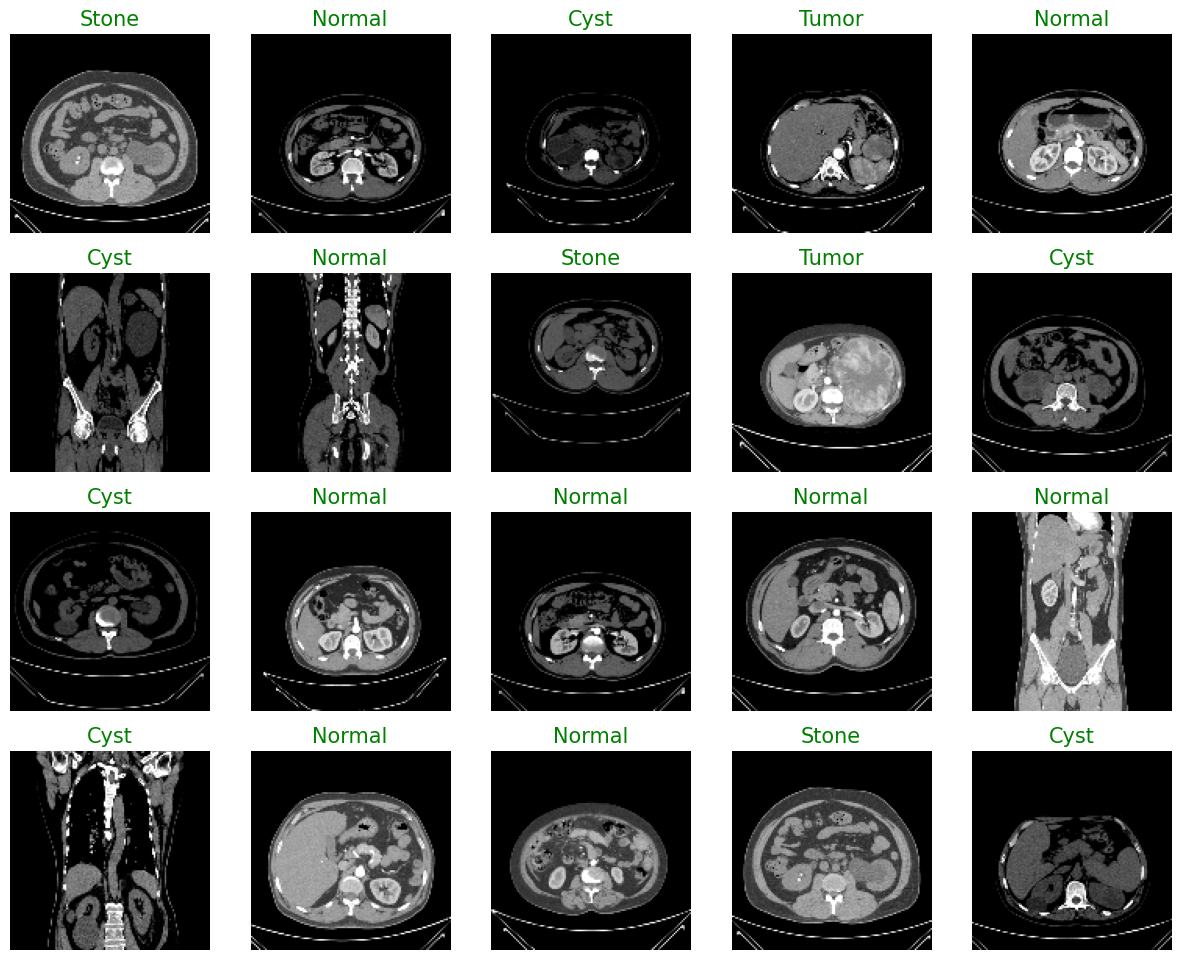

In [13]:
plot_some_images(Training_Set, 20)

**2.Testing Set**

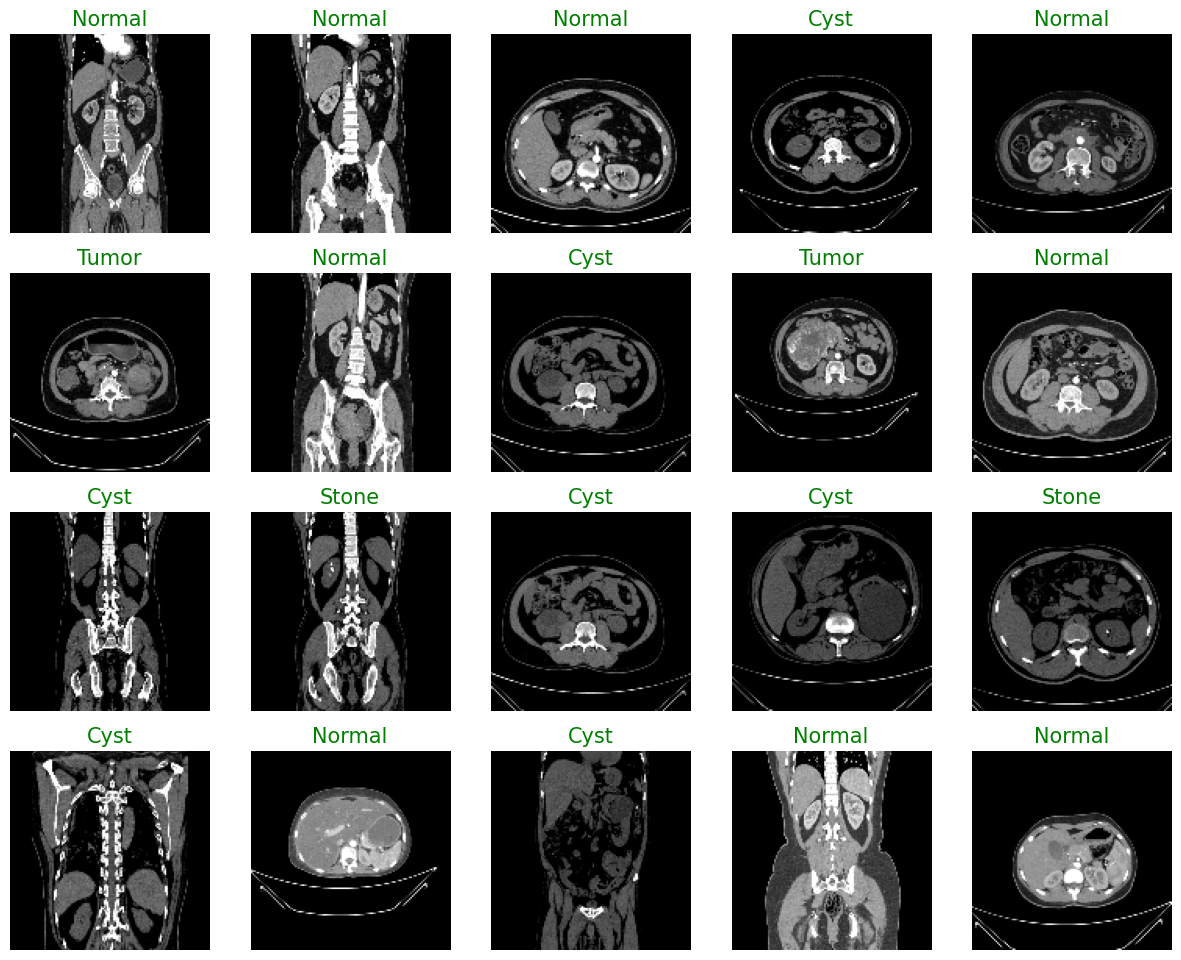

In [14]:
plot_some_images(Testing_Set, 20)

**3. Validation Set**

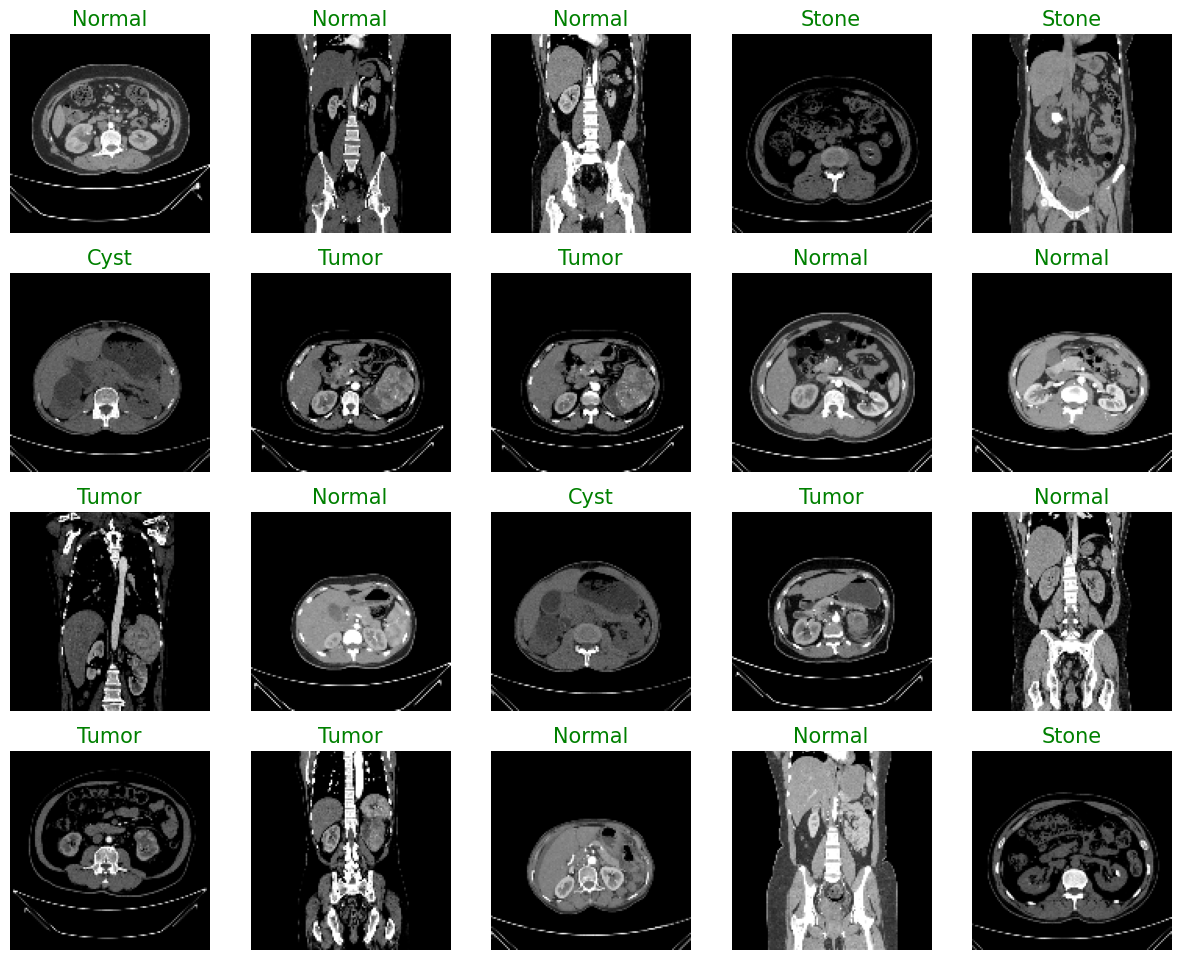

In [15]:
plot_some_images(Validation_Set, 20)

# Models

In [16]:
Input_Shape = (Image_Height, Image_Width, 1)
Epochs = 100
Number_Of_Classes = len(os.listdir(ImagePath))

In [17]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    patience=3,
                    verbose=0,
                    mode="max",
                    restore_best_weights=True,
                    start_from_epoch=0
                )

In [18]:
Predictin_Image1 = r'./Prediction Images/Normal- (30).jpg'
Predictin_Image2 = r'./Prediction Images/Cyst- (22).jpg'
Predictin_Image3 = r'./Prediction Images/Stone- (5).jpg'
Predictin_Image4 = r'./Prediction Images/Tumor- (20).jpg'
Predictin_Image5 = r'./Prediction Images/Normal- (76).jpg'
Predictin_Image6 = r'./Prediction Images/Stone- (26).jpg'
Predictin_Image7 = r'./Prediction Images/Cyst- (38).jpg'
Predictin_Image8 = r'./Prediction Images/Tumor- (9).jpg'


In [19]:
class Models(): 
    def __init__(self,input_shape,epochs) :
        self.input_shape = input_shape
        self.epochs = epochs
        
    def convolutional_neural_network(self):
        '''Build Convolutional Neural Network For Images Classification, Compile It, Anf Fit It'''
        model = keras.models.Sequential([Rescaling(1./255),
                                         RandomFlip("horizontal_and_vertical"),
                                         Conv2D(32, 3, activation='relu', input_shape = self.input_shape),
                                         MaxPooling2D(),
                                         Conv2D(32, 3, activation='relu'),
                                         MaxPooling2D(),
                                         Conv2D(64, 3, activation='relu'),
                                         MaxPooling2D(),
                                         Conv2D(64, 3, activation='relu'),
                                         MaxPooling2D(),
                                         Conv2D(128, 3, activation='relu'),
                                         MaxPooling2D(),
                                         Flatten(),
                                         Dense(128 ,activation='relu'),
                                         Dense(Number_Of_Classes, activation='softmax')])
            
        model.compile(loss= 'categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

        
        model.fit(x= Training_Set, 
                  epochs=self.epochs, 
                  validation_data=Validation_Set,
                  callbacks=[Callback],
                  steps_per_epoch=None,
                  shuffle=True,
                  validation_batch_size = None,
                  batch_size=None,
                  initial_epoch	 = 0)
        
        return model
    

    def tranfer_learning(self, base_model):  
        '''Define Transfer Learning Models For Images Classification, Compile It, Anf Fit It'''

        base_model = base_model
        base_model.trainable = True

        inputs = tf.keras.Input(self.input_shape)
        GrayScaleImage = tf.keras.layers.Concatenate()([inputs, inputs, inputs])
        x = Rescaling(1./255)(GrayScaleImage)
        x = RandomFlip("horizontal_and_vertical")(x)
        x = base_model(x)
        outputs = Dense(Number_Of_Classes, 'softmax')(x)
        model = tf.keras.Model(inputs, outputs)
          
        model.compile(loss= 'categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

        model.fit(x = Training_Set, 
                  epochs=self.epochs, 
                  validation_data=Validation_Set,
                  callbacks=[Callback],
                  steps_per_epoch=None,
                  shuffle=True,
                  validation_batch_size = None,
                  batch_size=None,
                  initial_epoch	= 0)
        
        return model    

# Model History Result

In [20]:
def model_history_values(model, name):
    '''Export The Model Training Accuracy, Training Loss, Validation Accuracy, Validation Loss To DataFrame And CSV File'''
    file_name = name
    HistoryResultDF= pd.DataFrame(model.history.history)
    HistoryResultDF.to_csv(os.path.join('{}HitoryResult.csv'.format(file_name)) ,index=False)
    return HistoryResultDF

# Ploting Model History

In [21]:
def plot_model_history(ModelHistory): 
        '''Plot The Model Training Accuracy, Training Loss, Validation Accuracy, Validation Loss '''
        figure, ax = plt.subplots(2, 1, figsize=(10, 10))
        ModelHistory[['accuracy', 'val_accuracy']].plot(ax=ax[0],title='Accuracy');
        ModelHistory[['loss', 'val_loss']].plot(ax=ax[1], title='Loss');


# Find Model Values

In [22]:
class ModelValues():
        def __init__(self, HistoryResultDF) :
                self.HistoryResultDF = HistoryResultDF

        def loss_accuracy_values(self):
                '''Find The Mean Value Of The Model Training Accuracy, Training Loss, Validation Accuracy, Validation Loss And Export As Dataframe'''

                Loss = self.HistoryResultDF['loss'].mean()
                Accuracy = self.HistoryResultDF['accuracy'].mean()
                ValLoss = self.HistoryResultDF['val_loss'].mean()
                ValAccuracy = self.HistoryResultDF['val_accuracy'].mean()
                LossAccuracyValuesDf =  pd.DataFrame(data=[Loss, Accuracy, ValLoss, ValAccuracy], index=['Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy'], columns=['Values'])

                return Loss, Accuracy, ValLoss, ValAccuracy, LossAccuracyValuesDf

        def loss_accuracy_valuesـmaximum_values(self):
                '''Find The Maximum Value Of The Model Training Accuracy, Training Loss, Validation Accuracy, Validation Loss And Export As Dataframe'''

                MaxLoss = self.HistoryResultDF['loss'].max()
                MaxAccuracy = self.HistoryResultDF['accuracy'].max()
                MaxValLoss = self.HistoryResultDF['val_loss'].max()
                MaxValAccuracy = self.HistoryResultDF['val_accuracy'].max()
                MaxLossAccuracyValuesDf =  pd.DataFrame(data=[MaxLoss, MaxAccuracy, MaxValLoss, MaxValAccuracy], index=['Max_Loss', 'Max_Accuracy', 'Max_Val_Loss', 'Max_Val_Accuracy'], columns=['Values'])

                return MaxLoss, MaxAccuracy, MaxValLoss, MaxValAccuracy, MaxLossAccuracyValuesDf

        def loss_accuracy_valuesـminimum_values(self):
                '''Find The Minimum Value Of The Model Training Accuracy, Training Loss, Validation Accuracy, Validation Loss And Export As Dataframe'''

                MinLoss = self.HistoryResultDF['loss'].min()
                MinAccuracy = self.HistoryResultDF['accuracy'].min()
                MinValLoss = self.HistoryResultDF['val_loss'].min()
                MinValAccuracy = self.HistoryResultDF['val_accuracy'].min()
                MinLossAccuracyValuesDf =  pd.DataFrame(data=[MinLoss, MinAccuracy, MinValLoss, MinValAccuracy], index=['Min_Loss', 'Min_Accuracy', 'Min_Val_Loss', 'Min_Val_Accuracy'], columns=['Values'])

                return MinLoss, MinAccuracy, MinValLoss, MinValAccuracy, MinLossAccuracyValuesDf

# Model Evaluation

In [23]:
def model_evulation(model, data):
    '''Find The Testing Accuracy And Testing Loss And Export As Dataframe '''
    Loss, Accuracy = model.evaluate(data, verbose=0)

    EvaluationValues = pd.DataFrame(index= ['Loss', 'Accuracy'], data = [Loss, Accuracy], columns=['Values'])
    
    return Loss, Accuracy, EvaluationValues

# Generate Real And Prediction Classes

In [24]:
def generate_real_prediction_classes(model):
    '''Generate The Real And Predection Classes For Use In Confusion Matrix And Performance Metrics '''

    Real =  np.array([])
    Predictions = np.array([])
    
    for x, y in Testing_Set:
        Real = np.concatenate((Real, np.argmax(y, axis=1)))
        y_pred = np.argmax(model.predict(x, verbose=0),axis=1)
        Predictions = np.concatenate([Predictions, y_pred])
        
        if len(Real) == len(Testing_Set.file_paths):
            break

    return Real, Predictions

# Confusion Matrix

In [25]:
def confusion_matrix_(Real, Prediction):
        '''The confusion matrix is used to analyze the ability of model to identify the classes of the dataset'''

        ConfusionMatrix = confusion_matrix(Real, Prediction)
    
        return ConfusionMatrix
    
def plot_confusion_matrix(ConfusionMatrix, name):
    '''Display The Confusion Matrix'''
    
    disp = ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix, display_labels = Testing_Set.class_names)
    disp.plot(cmap='YlGnBu', colorbar=False, xticks_rotation='vertical', values_format='d')
    plt.title('{} Confusion Matrix with Labels'.format(name))
    plt.rcParams['font.size'] = '10'
    plt.grid(None)
    return plt.show();

# Model Performance Metrics

**1. Generate True Positive, False Positive, True Negative, False Negative**

*A. Positive*

In [26]:
class Generate_Positive():     
    def __init__(self, Confusin_Matrix):
        self.Confusin_Matrix = Confusin_Matrix
    
    def false_positive(self):
        '''The prediction is wrong and the real value is positive 
        Using numpy to find the values of false positive from confusion matrix'''

        False_Postive = self.Confusin_Matrix.sum(axis=0) - np.diag(self.Confusin_Matrix)
        False_Postive = False_Postive.astype(int)
        False_Postive = sum(False_Postive)
        
        return False_Postive
        
    def true_positive(self):
        ''' The prediction is correct and the real value is positive 
        Using numpy to find the values of true positive from confusion matrix'''

        True_Positive = np.diag(self.Confusin_Matrix)
        True_Positive = True_Positive.astype(int)
        True_Positive = sum(True_Positive)
        
        return True_Positive


*B. Negative*

In [27]:
class Generate_Negative():
    
    def __init__(self, Confusin_Matrix):
        self.Confusin_Matrix = Confusin_Matrix
    
    def false_negative(self):
        '''The prediction is wrong and the real value is negative 
        Using numpy to find the values of false negative from confusion matrix'''

        False_Negative = self.Confusin_Matrix.sum(axis=1) - np.diag(self.Confusin_Matrix)
        False_Negative = False_Negative.astype(int)
        False_Negative = sum(False_Negative)
        
        return False_Negative 
    
    def true_negative(self):
         ''' The prediction is correct and the real value is negative 
         Using numpy to find the values of true negative from confusion matrix'''

         True_Negative = self.Confusin_Matrix.sum()
         X = (self.Confusin_Matrix.sum(axis=0) - np.diag(self.Confusin_Matrix)) + (self.Confusin_Matrix.sum(axis=1) - np.diag(self.Confusin_Matrix)) + np.diag(self.Confusin_Matrix)
         True_Negative = True_Negative.astype(int) - X
         True_Negative = sum(True_Negative)
         
         return True_Negative

**2. Performance Merics**

In [28]:
class Performance_Metrics:
    
    def __init__(self, True_Positive, True_Negative, False_Positive, False_Negative):
        self.True_Positive = True_Positive
        self.True_Negative = True_Negative
        self.False_Positive = False_Positive
        self.False_Negative = False_Negative
        
            
    def accuracy_score(self):
        ''' Accuracy is using to measure the accurate of the model '''
        Accuracy = (self.True_Positive + self.True_Negative) / (self.True_Positive + self.True_Negative + self.False_Positive + self.False_Negative)

        return Accuracy
    
    def precision_score(self):
        '''Precision is used to identified is the predicted result is close to the real result'''
        
        Precision = ((self.True_Positive) / (self.True_Positive + self.False_Positive))
        
        return Precision
    
    def sensitivity_score(self):
        '''Sensitivity is true positive rate measure'''

        Sensitivity = ((self.True_Positive ) / (self.True_Positive  + self.False_Negative)) 

        return Sensitivity
     
    def specificity_score(self):
        '''Specificity is true negative rate measure'''

        Specificity = ((self.True_Negative) / (self.True_Negative + self.False_Negative)) 

        return Specificity
    
    def f1_score(self):
        '''F-Measure refers to the mean of consistency between precision and sensitivity'''
        
        F1Score = (((self.True_Positive ) / (self.True_Positive  + self.False_Negative) * (self.True_Positive) / (self.True_Positive + self.False_Positive)) / ((self.True_Positive ) / (self.True_Positive  + self.False_Negative) + (self.True_Positive) / (self.True_Positive + self.False_Positive))) * 2

        return F1Score
    
    def err_rate(self):
        Error = ((self.False_Positive + self.False_Negative) / (self.True_Positive + self.True_Negative + self.False_Positive + self.False_Negative)) 
  
        return Error 
    
    @staticmethod 
    def display_performance_metrics_values(Accuracy, Precision, Sensitivity, Specificity, F1Score, Error):
        MetricsValues = pd.DataFrame(index=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1Score', 'Error'], columns=['Values'], data=[Accuracy, Precision, Sensitivity, Specificity, F1Score, Error])

        return MetricsValues   
    

# Predict Images

In [29]:
def predict(prediction):
    if np.argmax(prediction) == 0:
        print('Cyst')
    elif np.argmax(prediction) == 1:
        print('Normal')   
    elif np.argmax(prediction) == 2:
        print('Stone')    
    elif np.argmax(prediction) == 3:
        print('Tumor')
    else:
        print('Unkown')

def predict_image(model, path):

    PredictionImage = tf.keras.utils.load_img(path, target_size=(Image_Height, Image_Width, 1))
    PredictionImageArray = tf.keras.utils.img_to_array(PredictionImage)
    PredictionImageArray = np.array([PredictionImageArray])
    GrayScaleImages = tf.image.rgb_to_grayscale(PredictionImageArray)
    predictions = model.predict(GrayScaleImages)
    Predction = predict(predictions)
    return Predction

# Convolutional Neural Network

In [30]:
name = 'Convolutional Neural Network'

In [31]:
with tf.device('GPU'):
    model = Models(Input_Shape, Epochs)
    model0 = model.convolutional_neural_network()

Epoch 1/100
156/156 [==============================] - 14s 81ms/step - loss: 0.9435 - accuracy: 0.6278 - val_loss: 0.7377 - val_accuracy: 0.7110
Epoch 2/100
156/156 [==============================] - 12s 75ms/step - loss: 0.5676 - accuracy: 0.7701 - val_loss: 0.3335 - val_accuracy: 0.8680
Epoch 3/100
156/156 [==============================] - 12s 77ms/step - loss: 0.3263 - accuracy: 0.8740 - val_loss: 0.2000 - val_accuracy: 0.9251
Epoch 4/100
156/156 [==============================] - 14s 88ms/step - loss: 0.1894 - accuracy: 0.9284 - val_loss: 0.1042 - val_accuracy: 0.9581
Epoch 5/100
156/156 [==============================] - 14s 84ms/step - loss: 0.1481 - accuracy: 0.9465 - val_loss: 0.0861 - val_accuracy: 0.9646
Epoch 6/100
156/156 [==============================] - 12s 77ms/step - loss: 0.0997 - accuracy: 0.9650 - val_loss: 0.1271 - val_accuracy: 0.9557
Epoch 7/100
156/156 [==============================] - 13s 80ms/step - loss: 0.0737 - accuracy: 0.9745 - val_loss: 0.0716 - val_ac

In [32]:
HistoryResultDF0 = model_history_values(model0, name)

In [33]:
HistoryResultDF0

,loss,accuracy,val_loss,val_accuracy
0,0.943486,0.627802,0.737694,0.710950
1,0.567605,0.770128,0.333544,0.867955
2,0.326260,0.873957,0.200038,0.925121
3,0.189364,0.928435,0.104170,0.958132
4,0.148149,0.946527,0.086071,0.964573
5,0.099685,0.965022,0.127067,0.955717
6,0.073664,0.974470,0.071585,0.975040
7,0.061864,0.979194,0.024207,0.991948
8,0.039955,0.987235,0.052565,0.984702
9,0.071661,0.979194,0.014563,0.997585


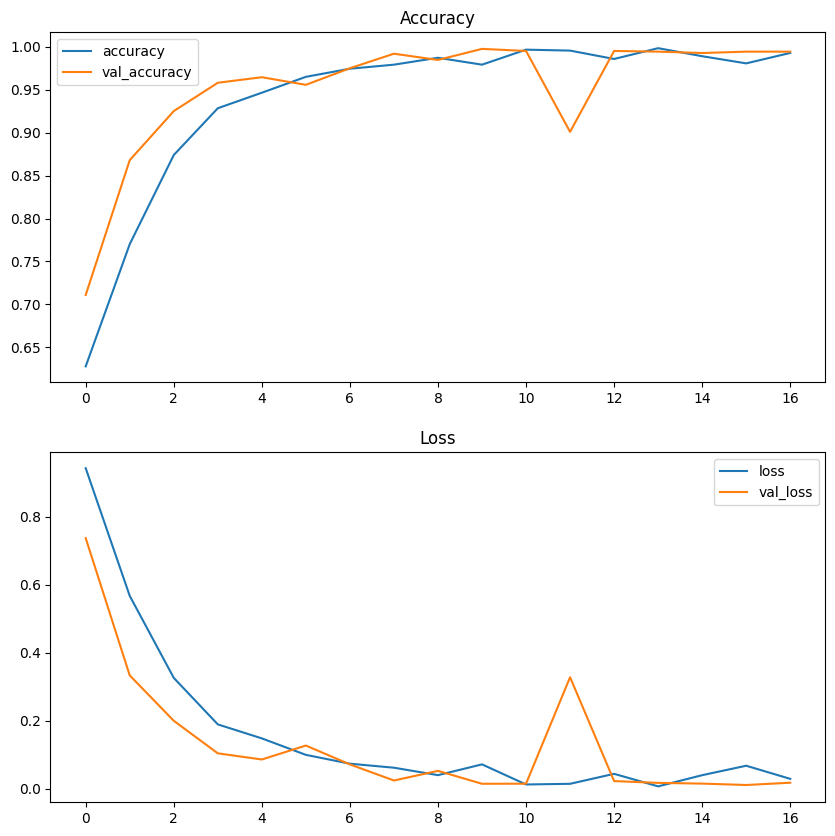

In [34]:
plot_model_history(HistoryResultDF0)

In [35]:
ModelValues0 = ModelValues(HistoryResultDF0)
Loss0, Accuracy0, ValLoss0, ValAccuracy0, LossAccuracyValuesDf0 = ModelValues0.loss_accuracy_values()
MaxLoss0, MaxAccuracy0, MaxValLoss0, MaxValAccuracy0, MaxLossAccuracyValuesDf0 = ModelValues0.loss_accuracy_valuesـmaximum_values()
MinLoss0, MinAccuracy0, MinValLoss0, MinValAccuracy0, MinLossAccuracyValuesDf0 = ModelValues0.loss_accuracy_valuesـminimum_values()

In [36]:
LossAccuracyValuesDf0

,Values
Loss,0.160938
Accuracy,0.939474
Val_Loss,0.128112
Val_Accuracy,0.952875


In [37]:
MaxLossAccuracyValuesDf0

,Values
Max_Loss,0.943486
Max_Accuracy,0.998392
Max_Val_Loss,0.737694
Max_Val_Accuracy,0.997585


In [38]:
MinLossAccuracyValuesDf0

,Values
Min_Loss,0.006925
Min_Accuracy,0.627802
Min_Val_Loss,0.010981
Min_Val_Accuracy,0.710950


In [39]:
TestingLoss0, TestingAccuracy0, EvaluationValues0 = model_evulation(model0, Testing_Set)

In [40]:
EvaluationValues0

,Values
Loss,0.044894
Accuracy,0.991981


In [41]:
Real0, Predictions0 = generate_real_prediction_classes(model0)

In [42]:
ConfusionMatrix0 = confusion_matrix_(Real0, Predictions0)

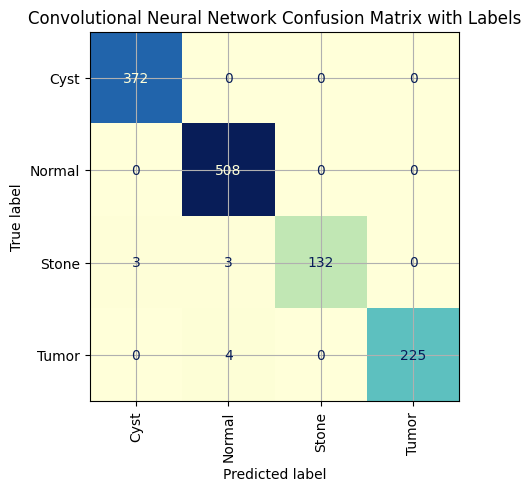

In [43]:
plot_confusion_matrix(ConfusionMatrix0, name)

In [44]:
Positive0 = Generate_Positive(ConfusionMatrix0)
TruePositive0 = Positive0.true_positive()
FalsePostive0 = Positive0.false_positive()

In [45]:
Negative0 = Generate_Negative(ConfusionMatrix0)
TrueNegative0 = Negative0.true_negative()
FalseNegative0 = Negative0.false_negative()

In [46]:
Performance0 = Performance_Metrics(TruePositive0, TrueNegative0 ,FalsePostive0, FalseNegative0)

Accuracy0 = Performance0.accuracy_score()
Precision0 = Performance0.precision_score()
Sensitivity0 = Performance0.sensitivity_score()
Specificity0 = Performance0.specificity_score()
F1Score0 = Performance0.f1_score()
ErrorRate0 = Performance0.err_rate()

PerformanceValues0 = Performance0.display_performance_metrics_values(Accuracy0, Precision0, Sensitivity0, Specificity0, F1Score0, ErrorRate0)

In [47]:
PerformanceValues0

,Values
Accuracy,0.995990
Precision,0.991981
Sensitivity,0.991981
Specificity,0.997327
F1Score,0.991981
Error,0.004010


In [48]:
predict_image(model0, Predictin_Image1)

1/1 [==============================] - 0s 71ms/step
Normal


In [49]:
predict_image(model0, Predictin_Image2)

1/1 [==============================] - 0s 13ms/step
Cyst


In [50]:
predict_image(model0, Predictin_Image3)

1/1 [==============================] - 0s 13ms/step
Stone


In [51]:
predict_image(model0, Predictin_Image4)

1/1 [==============================] - 0s 13ms/step
Tumor


In [52]:
predict_image(model0, Predictin_Image5)

1/1 [==============================] - 0s 12ms/step
Normal


In [53]:
predict_image(model0, Predictin_Image6)

1/1 [==============================] - 0s 15ms/step
Stone


In [54]:
predict_image(model0, Predictin_Image7)

1/1 [==============================] - 0s 12ms/step
Cyst


In [55]:
predict_image(model0, Predictin_Image8)

1/1 [==============================] - 0s 13ms/step
Tumor


In [56]:
model0.save("model0.h5")

# Transfer Learning

**1. InceptionV3**

In [57]:
name = 'InceptionV3'

In [58]:
with tf.device('GPU'):
    base_model = tf.keras.applications.inception_v3.InceptionV3(
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'
                    )

    Inc = Models(Input_Shape, Epochs)
    model1 = Inc.tranfer_learning(base_model)

Epoch 1/100
156/156 [==============================] - 95s 573ms/step - loss: 0.3634 - accuracy: 0.8730 - val_loss: 1.3663 - val_accuracy: 0.6626
Epoch 2/100
156/156 [==============================] - 86s 546ms/step - loss: 0.1086 - accuracy: 0.9633 - val_loss: 0.3174 - val_accuracy: 0.9122
Epoch 3/100
156/156 [==============================] - 83s 531ms/step - loss: 0.0761 - accuracy: 0.9745 - val_loss: 0.8677 - val_accuracy: 0.7842
Epoch 4/100
156/156 [==============================] - 86s 552ms/step - loss: 0.0416 - accuracy: 0.9876 - val_loss: 0.1633 - val_accuracy: 0.9412
Epoch 5/100
156/156 [==============================] - 95s 606ms/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 0.0450 - val_accuracy: 0.9855
Epoch 6/100
156/156 [==============================] - 93s 588ms/step - loss: 0.0273 - accuracy: 0.9921 - val_loss: 0.0957 - val_accuracy: 0.9702
Epoch 7/100
156/156 [==============================] - 76s 488ms/step - loss: 0.0251 - accuracy: 0.9923 - val_loss: 0.0276 -

In [59]:
HistoryResultDF1 = model_history_values(model1, name)

In [60]:
HistoryResultDF1

,loss,accuracy,val_loss,val_accuracy
0,0.363432,0.872952,1.366251,0.662641
1,0.108601,0.963313,0.317418,0.912238
2,0.076134,0.974470,0.867675,0.784219
3,0.041566,0.987637,0.163329,0.941224
4,0.038688,0.987838,0.044984,0.985507
5,0.027298,0.992060,0.095689,0.970209
6,0.025113,0.992261,0.027568,0.993559
7,0.016175,0.995175,0.216290,0.927536
8,0.041608,0.987536,0.061876,0.978261
9,0.011931,0.996784,0.004522,0.998390


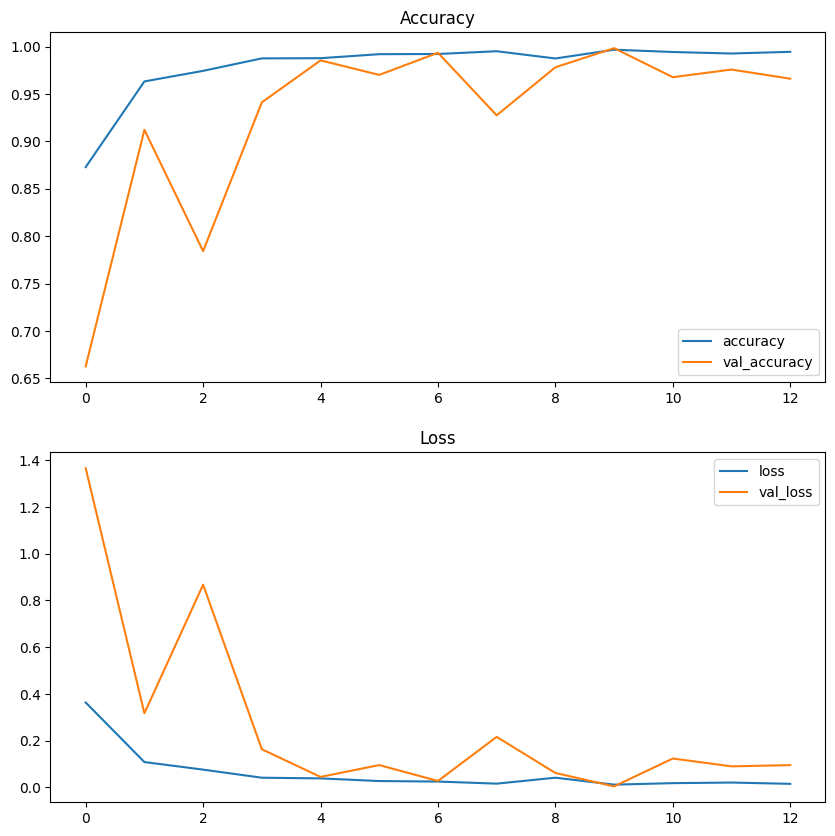

In [61]:
plot_model_history(HistoryResultDF1)

In [62]:
ModelValues1 = ModelValues(HistoryResultDF1)
Loss1, Accuracy1, ValLoss1, ValAccuracy1, LossAccuracyValuesDf1 = ModelValues1.loss_accuracy_values()
MaxLoss1, MaxAccuracy1, MaxValLoss1, MaxValAccuracy1, MaxLossAccuracyValuesDf1 = ModelValues1.loss_accuracy_valuesـmaximum_values()
MinLoss1, MinAccuracy1, MinValLoss1, MinValAccuracy1, MinLossAccuracyValuesDf1 = ModelValues1.loss_accuracy_valuesـminimum_values()

In [63]:
LossAccuracyValuesDf1

,Values
Loss,0.061929
Accuracy,0.979364
Val_Loss,0.267312
Val_Accuracy,0.927970


In [64]:
MaxLossAccuracyValuesDf1

,Values
Max_Loss,0.363432
Max_Accuracy,0.996784
Max_Val_Loss,1.366251
Max_Val_Accuracy,0.998390


In [65]:
MinLossAccuracyValuesDf1

,Values
Min_Loss,0.011931
Min_Accuracy,0.872952
Min_Val_Loss,0.004522
Min_Val_Accuracy,0.662641


In [66]:
TestingLoss1, TestingAccuracy1, EvaluationValues1 = model_evulation(model1, Testing_Set)

In [67]:
EvaluationValues1

,Values
Loss,0.007282
Accuracy,0.996792


In [68]:
Real1, Predictions1 = generate_real_prediction_classes(model1)

In [69]:
ConfusionMatrix1 = confusion_matrix_(Real1, Predictions1)

In [70]:
Positive1 = Generate_Positive(ConfusionMatrix1)
TruePositive1 = Positive1.true_positive()
FalsePostive1 = Positive1.false_positive()

In [71]:
Negative1 = Generate_Negative(ConfusionMatrix1)
TrueNegative1 = Negative1.true_negative()
FalseNegative1 = Negative1.false_negative()

In [72]:
Performance1 = Performance_Metrics(TruePositive1, TrueNegative1 ,FalsePostive1, FalseNegative1)

Accuracy1 = Performance1.accuracy_score()
Precision1 = Performance1.precision_score()
Sensitivity1 = Performance1.sensitivity_score()
Specificity1 = Performance1.specificity_score()
F1Score1 = Performance1.f1_score()
ErrorRate1 = Performance1.err_rate()

PerformanceValues1 = Performance1.display_performance_metrics_values(Accuracy1, Precision1, Sensitivity1, Specificity1, F1Score1, ErrorRate1)

In [73]:
PerformanceValues1

,Values
Accuracy,0.998396
Precision,0.996792
Sensitivity,0.996792
Specificity,0.998931
F1Score,0.996792
Error,0.001604


In [74]:
predict_image(model1, Predictin_Image1)

1/1 [==============================] - 1s 1s/step
Normal


In [75]:
predict_image(model1, Predictin_Image2)

1/1 [==============================] - 0s 184ms/step
Cyst


In [76]:
predict_image(model1, Predictin_Image3)

1/1 [==============================] - 0s 30ms/step
Stone


In [77]:
predict_image(model1, Predictin_Image4)

1/1 [==============================] - 0s 45ms/step
Tumor


In [78]:
predict_image(model1, Predictin_Image5)

1/1 [==============================] - 0s 32ms/step
Normal


In [79]:
predict_image(model1, Predictin_Image6)

1/1 [==============================] - 0s 34ms/step
Stone


In [80]:
predict_image(model1, Predictin_Image7)

1/1 [==============================] - 0s 30ms/step
Cyst


In [81]:
predict_image(model1, Predictin_Image8)

1/1 [==============================] - 0s 372ms/step
Tumor


In [82]:
model1.save("model1.h5")

**2. DenseNet121**

In [83]:
name = 'DenseNet121'

In [84]:
with tf.device('GPU'):
        base_model = tf.keras.applications.densenet.DenseNet121(
                include_top=False,
                weights='imagenet',
                pooling='avg'                    
                )

        NetV2B0 = Models(Input_Shape, Epochs)
        model2 = NetV2B0.tranfer_learning(base_model)

Epoch 1/100
156/156 [==============================] - 184s 1s/step - loss: 0.2796 - accuracy: 0.9042 - val_loss: 7.3193 - val_accuracy: 0.3784
Epoch 2/100
156/156 [==============================] - 150s 956ms/step - loss: 0.0749 - accuracy: 0.9742 - val_loss: 1.2276 - val_accuracy: 0.7061
Epoch 3/100
156/156 [==============================] - 150s 955ms/step - loss: 0.0448 - accuracy: 0.9851 - val_loss: 1.1092 - val_accuracy: 0.7689
Epoch 4/100
156/156 [==============================] - 144s 920ms/step - loss: 0.0361 - accuracy: 0.9883 - val_loss: 0.2820 - val_accuracy: 0.9082
Epoch 5/100
156/156 [==============================] - 144s 920ms/step - loss: 0.0201 - accuracy: 0.9928 - val_loss: 0.0239 - val_accuracy: 0.9903
Epoch 6/100
156/156 [==============================] - 144s 924ms/step - loss: 0.0127 - accuracy: 0.9957 - val_loss: 0.8940 - val_accuracy: 0.8615
Epoch 7/100
156/156 [==============================] - 143s 916ms/step - loss: 0.0641 - accuracy: 0.9787 - val_loss: 0.46

In [85]:
HistoryResultDF2 = model_history_values(model2, name)

In [86]:
HistoryResultDF2

,loss,accuracy,val_loss,val_accuracy
0,0.279577,0.904211,7.319306,0.378422
1,0.074893,0.974168,1.227570,0.706119
2,0.044781,0.985124,1.109202,0.768921
3,0.036105,0.988341,0.281986,0.908213
4,0.020139,0.992763,0.023937,0.990338
5,0.012725,0.995678,0.893984,0.861514
6,0.064114,0.978691,0.465392,0.884863
7,0.017531,0.993869,0.270342,0.937198
8,0.019159,0.993768,0.024384,0.991948


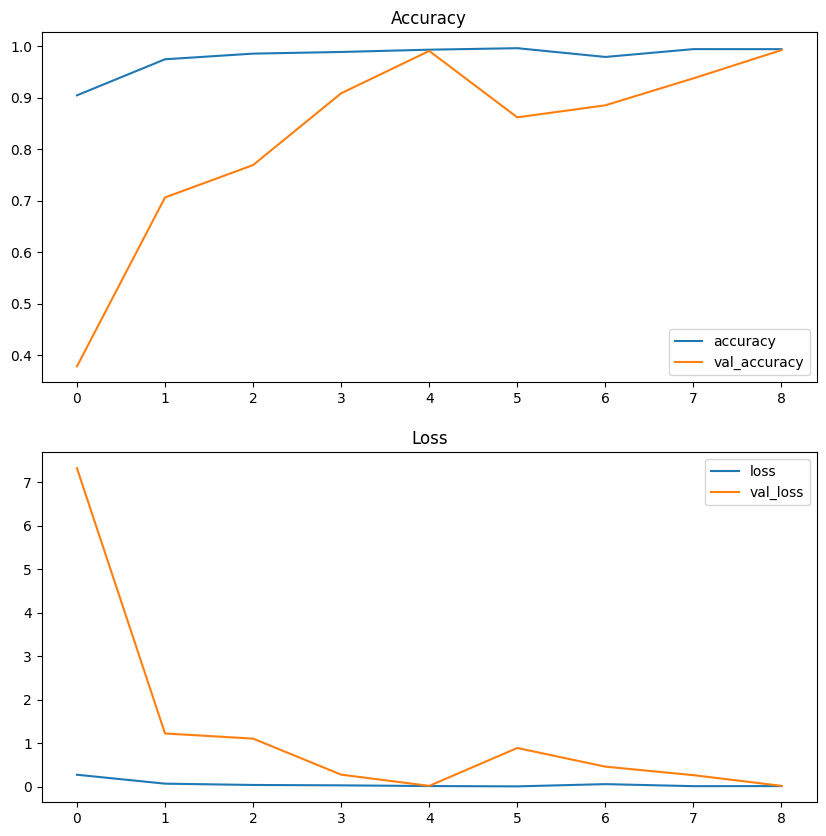

In [87]:
plot_model_history(HistoryResultDF2)

In [88]:
ModelValues2 = ModelValues(HistoryResultDF2)
Loss2, Accuracy2, ValLoss2, ValAccuracy2, LossAccuracyValuesDf2 = ModelValues2.loss_accuracy_values()
MaxLoss2, MaxAccuracy2, MaxValLoss2, MaxValAccuracy2, MaxLossAccuracyValuesDf2 = ModelValues2.loss_accuracy_valuesـmaximum_values()
MinLoss2, MinAccuracy2, MinValLoss2, MinValAccuracy2, MinLossAccuracyValuesDf2 = ModelValues2.loss_accuracy_valuesـminimum_values()

In [89]:
LossAccuracyValuesDf2

,Values
Loss,0.063225
Accuracy,0.978513
Val_Loss,1.290678
Val_Accuracy,0.825282


In [90]:
MaxLossAccuracyValuesDf2

,Values
Max_Loss,0.279577
Max_Accuracy,0.995678
Max_Val_Loss,7.319306
Max_Val_Accuracy,0.991948


In [91]:
MinLossAccuracyValuesDf2

,Values
Min_Loss,0.012725
Min_Accuracy,0.904211
Min_Val_Loss,0.023937
Min_Val_Accuracy,0.378422


In [92]:
TestingLoss2, TestingAccuracy2, EvaluationValues2 = model_evulation(model2, Testing_Set)

In [93]:
EvaluationValues2

,Values
Loss,0.955752
Accuracy,0.866079


In [94]:
Real2, Predictions2 = generate_real_prediction_classes(model2)

In [95]:
ConfusionMatrix2 = confusion_matrix_(Real2, Predictions2)

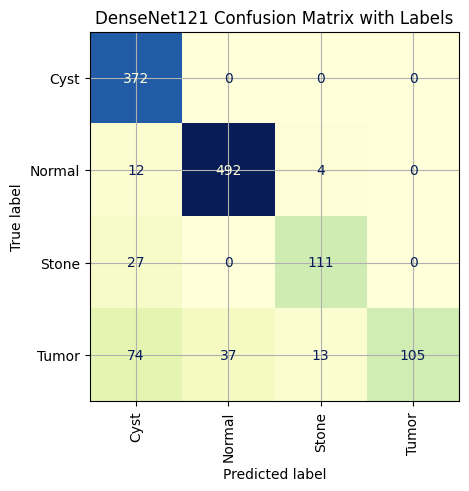

In [96]:
plot_confusion_matrix(ConfusionMatrix2, name)

In [97]:
Positive2 = Generate_Positive(ConfusionMatrix2)
TruePositive2= Positive2.true_positive()
FalsePostive2 = Positive2.false_positive()

In [98]:
Negative2 = Generate_Negative(ConfusionMatrix2)
TrueNegative2 = Negative2.true_negative()
FalseNegative2 = Negative2.false_negative()

In [99]:
Performance2 = Performance_Metrics(TruePositive2, TrueNegative2 ,FalsePostive2, FalseNegative2)

Accuracy2 = Performance2.accuracy_score()
Precision2 = Performance2.precision_score()
Sensitivity2 = Performance2.sensitivity_score()
Specificity2 = Performance2.specificity_score()
F1Score2 = Performance2.f1_score()
ErrorRate2 = Performance2.err_rate()

PerformanceValues2 = Performance2.display_performance_metrics_values(Accuracy2, Precision2, Sensitivity2, Specificity2, F1Score2, ErrorRate2)

In [100]:
PerformanceValues2

,Values
Accuracy,0.933039
Precision,0.866079
Sensitivity,0.866079
Specificity,0.955360
F1Score,0.866079
Error,0.066961


In [101]:
predict_image(model2, Predictin_Image1)

1/1 [==============================] - 3s 3s/step
Normal


In [102]:
predict_image(model2, Predictin_Image2)

1/1 [==============================] - 1s 925ms/step
Cyst


In [103]:
predict_image(model2, Predictin_Image3)

1/1 [==============================] - 0s 38ms/step
Stone


In [104]:
predict_image(model2, Predictin_Image4)

1/1 [==============================] - 0s 39ms/step
Normal


In [105]:
predict_image(model2, Predictin_Image5)

1/1 [==============================] - 0s 36ms/step
Normal


In [106]:
predict_image(model2, Predictin_Image6)

1/1 [==============================] - 0s 47ms/step
Stone


In [107]:
predict_image(model2, Predictin_Image7)

1/1 [==============================] - 0s 427ms/step
Cyst


In [108]:
predict_image(model2, Predictin_Image8)

1/1 [==============================] - 0s 38ms/step
Normal


In [109]:
model2.save("model2.h5")

**3. MobileNet**

In [110]:
name = 'MobileNet'

In [111]:
with tf.device('GPU'):
        base_model = tf.keras.applications.mobilenet.MobileNet(
                include_top=False,
                weights='imagenet',
                pooling='avg'
                )

        Mobile = Models(Input_Shape, Epochs)
        model3 = Mobile.tranfer_learning(base_model)

Epoch 1/100
156/156 [==============================] - 52s 302ms/step - loss: 0.3189 - accuracy: 0.9046 - val_loss: 1.3677 - val_accuracy: 0.7923
Epoch 2/100
156/156 [==============================] - 41s 264ms/step - loss: 0.0780 - accuracy: 0.9755 - val_loss: 1.8941 - val_accuracy: 0.6143
Epoch 3/100
156/156 [==============================] - 42s 265ms/step - loss: 0.0558 - accuracy: 0.9835 - val_loss: 0.2959 - val_accuracy: 0.9195
Epoch 4/100
156/156 [==============================] - 42s 265ms/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.0600 - val_accuracy: 0.9903
Epoch 5/100
156/156 [==============================] - 41s 261ms/step - loss: 0.0400 - accuracy: 0.9893 - val_loss: 0.3654 - val_accuracy: 0.9211
Epoch 6/100
156/156 [==============================] - 42s 266ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0063 - val_accuracy: 0.9984
Epoch 7/100
156/156 [==============================] - 43s 273ms/step - loss: 0.0212 - accuracy: 0.9936 - val_loss: 0.0802 -

In [112]:
HistoryResultDF3 = model_history_values(model3, name)

In [113]:
HistoryResultDF3

,loss,accuracy,val_loss,val_accuracy
0,0.318944,0.904614,1.367701,0.792271
1,0.078010,0.975475,1.894118,0.614332
2,0.055751,0.983516,0.295903,0.919485
3,0.029473,0.990049,0.060001,0.990338
4,0.040026,0.989346,0.365428,0.921095
5,0.014366,0.995376,0.006250,0.998390
6,0.021239,0.993567,0.080172,0.976651
7,0.023534,0.992964,0.032549,0.991948
8,0.014833,0.994874,0.075818,0.983897


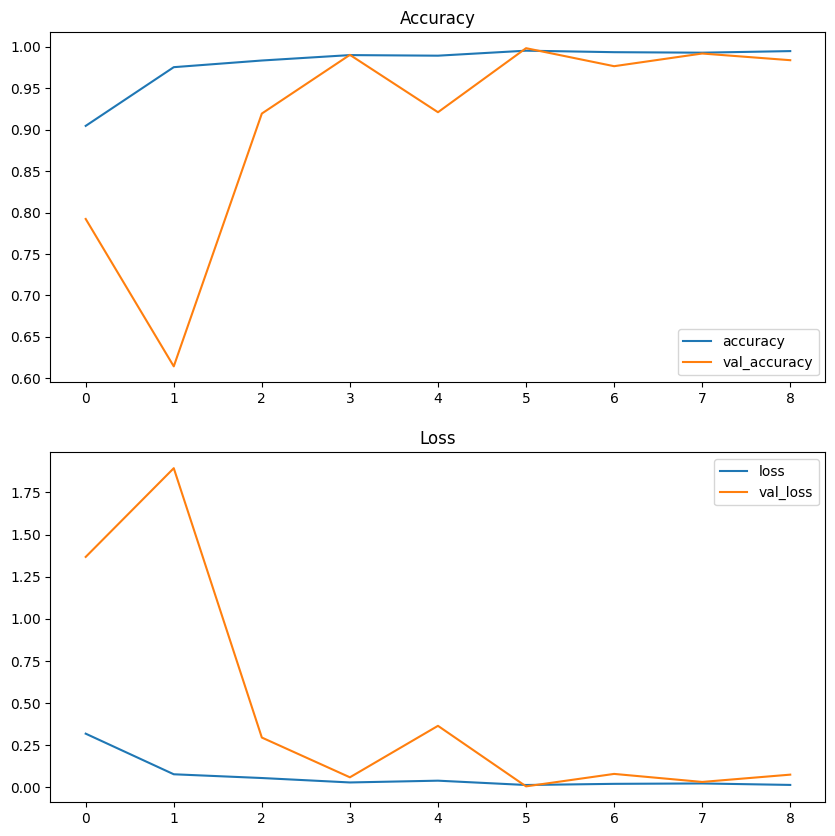

In [114]:
plot_model_history(HistoryResultDF3)

In [115]:
ModelValues3 = ModelValues(HistoryResultDF3)
Loss3, Accuracy3, ValLoss3, ValAccuracy3, LossAccuracyValuesDf3 = ModelValues3.loss_accuracy_values()
MaxLoss3, MaxAccuracy3, MaxValLoss3, MaxValAccuracy3, MaxLossAccuracyValuesDf3 = ModelValues3.loss_accuracy_valuesـmaximum_values()
MinLoss3, MinAccuracy3, MinValLoss3, MinValAccuracy3, MinLossAccuracyValuesDf3 = ModelValues3.loss_accuracy_valuesـminimum_values()

In [116]:
LossAccuracyValuesDf3

,Values
Loss,0.066242
Accuracy,0.979976
Val_Loss,0.464216
Val_Accuracy,0.909823


In [117]:
MaxLossAccuracyValuesDf3

,Values
Max_Loss,0.318944
Max_Accuracy,0.995376
Max_Val_Loss,1.894118
Max_Val_Accuracy,0.998390


In [118]:
MinLossAccuracyValuesDf3

,Values
Min_Loss,0.014366
Min_Accuracy,0.904614
Min_Val_Loss,0.006250
Min_Val_Accuracy,0.614332


In [119]:
TestingLoss3, TestingAccuracy3, EvaluationValues3 = model_evulation(model3, Testing_Set)

In [120]:
EvaluationValues3

,Values
Loss,0.020653
Accuracy,0.995188


In [121]:
Real3, Predictions3 = generate_real_prediction_classes(model3)

In [122]:
ConfusionMatrix3 = confusion_matrix_(Real3, Predictions3)

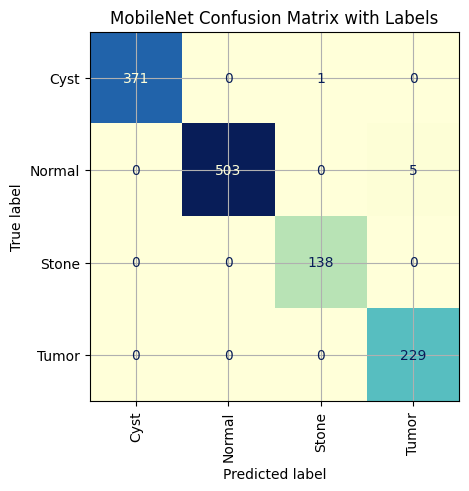

In [123]:
plot_confusion_matrix(ConfusionMatrix3, name)

In [124]:
Positive3 = Generate_Positive(ConfusionMatrix3)
TruePositive3 = Positive3.true_positive()
FalsePostive3 = Positive3.false_positive()

In [125]:
Negative3 = Generate_Negative(ConfusionMatrix3)
TrueNegative3 = Negative3.true_negative()
FalseNegative3 = Negative3.false_negative()

In [126]:
Performance3 = Performance_Metrics(TruePositive3, TrueNegative3 ,FalsePostive3, FalseNegative3)

Accuracy3 = Performance3.accuracy_score()
Precision3 = Performance3.precision_score()
Sensitivity3 = Performance3.sensitivity_score()
Specificity3 = Performance3.specificity_score()
F1Score3 = Performance3.f1_score()
ErrorRate3 = Performance3.err_rate()

PerformanceValues3 = Performance3.display_performance_metrics_values(Accuracy3, Precision3, Sensitivity3, Specificity3, F1Score3, ErrorRate3)

In [127]:
PerformanceValues3

,Values
Accuracy,0.997594
Precision,0.995188
Sensitivity,0.995188
Specificity,0.998396
F1Score,0.995188
Error,0.002406


In [128]:
predict_image(model3, Predictin_Image1)

1/1 [==============================] - 1s 721ms/step
Normal


In [129]:
predict_image(model3, Predictin_Image2)

1/1 [==============================] - 0s 83ms/step
Cyst


In [130]:
predict_image(model3, Predictin_Image3)

1/1 [==============================] - 0s 17ms/step
Stone


In [131]:
predict_image(model3, Predictin_Image4)

1/1 [==============================] - 0s 17ms/step
Tumor


In [132]:
predict_image(model3, Predictin_Image5)

1/1 [==============================] - 0s 18ms/step
Normal


In [133]:
predict_image(model3, Predictin_Image6)

1/1 [==============================] - 0s 31ms/step
Stone


In [134]:
predict_image(model3, Predictin_Image7)

1/1 [==============================] - 0s 17ms/step
Cyst


In [135]:
predict_image(model3, Predictin_Image8)

1/1 [==============================] - 0s 18ms/step
Tumor


In [136]:
model3.save("model3.h5")

**4. Xception**

In [137]:
name = 'Xception'

In [138]:
with tf.device('GPU'):
        base_model = tf.keras.applications.xception.Xception(
                include_top=False,
                weights='imagenet',
                pooling='avg'
        )

        XCE = Models(Input_Shape, Epochs)
        model4 = XCE.tranfer_learning(base_model)

Epoch 1/100
156/156 [==============================] - 184s 1s/step - loss: 0.3084 - accuracy: 0.8892 - val_loss: 0.8735 - val_accuracy: 0.8333
Epoch 2/100
156/156 [==============================] - 166s 1s/step - loss: 0.0712 - accuracy: 0.9778 - val_loss: 0.3508 - val_accuracy: 0.8849
Epoch 3/100
156/156 [==============================] - 167s 1s/step - loss: 0.0408 - accuracy: 0.9868 - val_loss: 0.2228 - val_accuracy: 0.9098
Epoch 4/100
156/156 [==============================] - 165s 1s/step - loss: 0.0301 - accuracy: 0.9907 - val_loss: 0.2293 - val_accuracy: 0.9324
Epoch 5/100
156/156 [==============================] - 166s 1s/step - loss: 0.0327 - accuracy: 0.9884 - val_loss: 0.0733 - val_accuracy: 0.9726
Epoch 6/100
156/156 [==============================] - 166s 1s/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.0235 - val_accuracy: 0.9928
Epoch 7/100
156/156 [==============================] - 165s 1s/step - loss: 0.0214 - accuracy: 0.9932 - val_loss: 0.0305 - val_accuracy:

In [139]:
HistoryResultDF4= model_history_values(model4, name)

In [140]:
HistoryResultDF4

,loss,accuracy,val_loss,val_accuracy
0,0.308359,0.889235,0.873528,0.833333
1,0.071184,0.977787,0.350797,0.884863
2,0.040785,0.986833,0.222840,0.909823
3,0.030142,0.990652,0.229338,0.932367
4,0.032728,0.988441,0.073321,0.972625
5,0.019244,0.993969,0.023507,0.992754
6,0.021445,0.993165,0.030543,0.982287
7,0.023236,0.992964,0.186474,0.927536
8,0.014835,0.995477,0.004642,0.998390
9,0.011578,0.995879,0.009155,0.997585


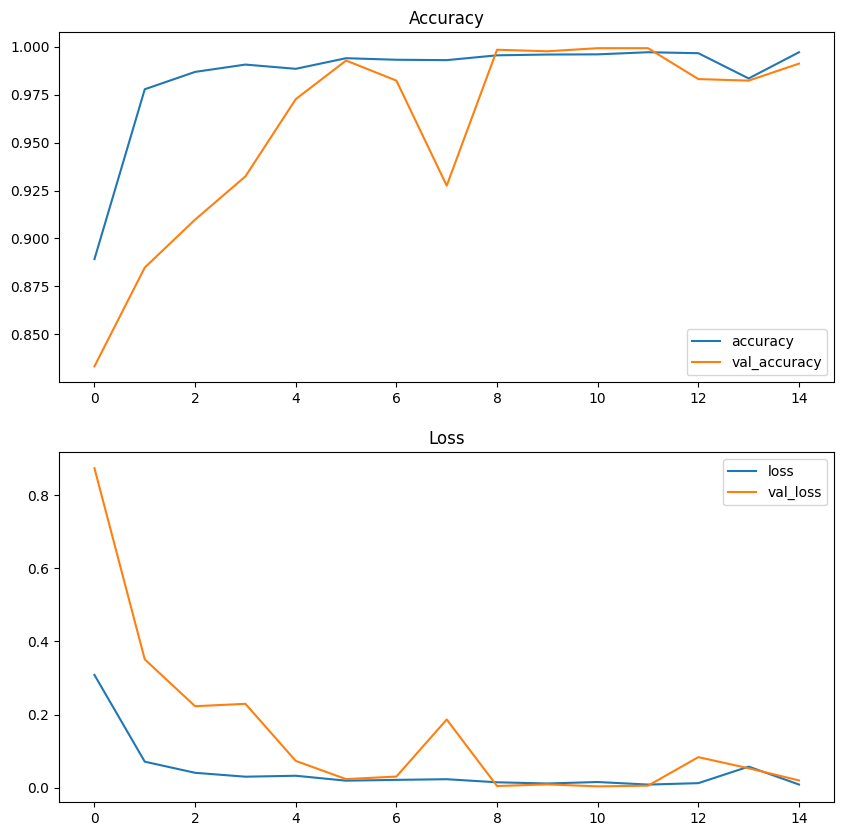

In [141]:
plot_model_history(HistoryResultDF4)

In [142]:
ModelValues4 = ModelValues(HistoryResultDF4)
Loss4, Accuracy4, ValLoss4, ValAccuracy4, LossAccuracyValuesDf4 = ModelValues4.loss_accuracy_values()
MaxLoss4, MaxAccuracy4, MaxValLoss4, MaxValAccuracy4, MaxLossAccuracyValuesDf4 = ModelValues4.loss_accuracy_valuesـmaximum_values()
MinLoss4, MinAccuracy4, MinValLoss4, MinValAccuracy4, MinLossAccuracyValuesDf4 = ModelValues4.loss_accuracy_valuesـminimum_values()

In [143]:
LossAccuracyValuesDf4

,Values
Loss,0.045104
Accuracy,0.984970
Val_Loss,0.144674
Val_Accuracy,0.959098


In [144]:
MaxLossAccuracyValuesDf4

,Values
Max_Loss,0.308359
Max_Accuracy,0.997085
Max_Val_Loss,0.873528
Max_Val_Accuracy,0.999195


In [145]:
MinLossAccuracyValuesDf4

,Values
Min_Loss,0.008576
Min_Accuracy,0.889235
Min_Val_Loss,0.003692
Min_Val_Accuracy,0.833333


In [146]:
TestingLoss4, TestingAccuracy4, EvaluationValues4 = model_evulation(model4, Testing_Set)

In [147]:
EvaluationValues4

,Values
Loss,0.030686
Accuracy,0.997594


In [148]:
Real4, Predictions4 = generate_real_prediction_classes(model4)

In [149]:
ConfusionMatrix4 = confusion_matrix_(Real4, Predictions4)

In [150]:
Positive4 = Generate_Positive(ConfusionMatrix4)
TruePositive4 = Positive4.true_positive()
FalsePostive4 = Positive4.false_positive()

In [151]:
Negative4 = Generate_Negative(ConfusionMatrix4)
TrueNegative4 = Negative1.true_negative()
FalseNegative4 = Negative1.false_negative()

In [152]:
Performance4 = Performance_Metrics(TruePositive4, TrueNegative4 ,FalsePostive4, FalseNegative4)

Accuracy4 = Performance4.accuracy_score()
Precision4 = Performance4.precision_score()
Sensitivity4 = Performance4.sensitivity_score()
Specificity4 = Performance4.specificity_score()
F1Score4 = Performance4.f1_score()
ErrorRate4 = Performance4.err_rate()

PerformanceValues4 = Performance4.display_performance_metrics_values(Accuracy4, Precision4, Sensitivity4, Specificity4, F1Score4, ErrorRate4)

In [153]:
PerformanceValues4

,Values
Accuracy,0.998597
Precision,0.997594
Sensitivity,0.996795
Specificity,0.998931
F1Score,0.997194
Error,0.001403


In [154]:
predict_image(model4, Predictin_Image1)

1/1 [==============================] - 1s 1s/step
Normal


In [155]:
predict_image(model4, Predictin_Image2)

1/1 [==============================] - 0s 438ms/step
Cyst


In [156]:
predict_image(model4, Predictin_Image3)

1/1 [==============================] - 0s 27ms/step
Stone


In [157]:
predict_image(model4, Predictin_Image4)

1/1 [==============================] - 0s 35ms/step
Tumor


In [158]:
predict_image(model4, Predictin_Image5)

1/1 [==============================] - 0s 22ms/step
Normal


In [159]:
predict_image(model4, Predictin_Image6)

1/1 [==============================] - 0s 22ms/step
Stone


In [160]:
predict_image(model4, Predictin_Image7)

1/1 [==============================] - 0s 22ms/step
Cyst


In [161]:
predict_image(model4, Predictin_Image8)

1/1 [==============================] - 0s 22ms/step
Tumor


In [162]:
model4.save("model4.h5")

**5. ResNet50**

In [163]:
name = 'ResNet50'

In [164]:
with tf.device('GPU'):
        base_model = tf.keras.applications.resnet50.ResNet50( 
                include_top=False,
                weights='imagenet',
                pooling='avg'
                )
        RES = Models(Input_Shape, Epochs)
        model5 = RES.tranfer_learning(base_model)

Epoch 1/100
156/156 [==============================] - 147s 869ms/step - loss: 0.3301 - accuracy: 0.8885 - val_loss: 1.4126 - val_accuracy: 0.4082
Epoch 2/100
156/156 [==============================] - 118s 757ms/step - loss: 0.0628 - accuracy: 0.9788 - val_loss: 1.6731 - val_accuracy: 0.4082
Epoch 3/100
156/156 [==============================] - 117s 749ms/step - loss: 0.0487 - accuracy: 0.9840 - val_loss: 1.7299 - val_accuracy: 0.3148
Epoch 4/100
156/156 [==============================] - 118s 754ms/step - loss: 0.0301 - accuracy: 0.9898 - val_loss: 10.1328 - val_accuracy: 0.2971
Epoch 5/100
156/156 [==============================] - 118s 752ms/step - loss: 0.0340 - accuracy: 0.9903 - val_loss: 16.8764 - val_accuracy: 0.2971
Epoch 6/100
156/156 [==============================] - 117s 750ms/step - loss: 0.0264 - accuracy: 0.9927 - val_loss: 2.6553 - val_accuracy: 0.3736
Epoch 7/100
156/156 [==============================] - 118s 755ms/step - loss: 0.0187 - accuracy: 0.9946 - val_loss:

In [165]:
HistoryResultDF5= model_history_values(model5, name)

In [166]:
HistoryResultDF5

,loss,accuracy,val_loss,val_accuracy
0,0.330074,0.888532,1.412573,0.408213
1,0.062783,0.978792,1.673064,0.408213
2,0.048666,0.984019,1.729912,0.314815
3,0.030138,0.989848,10.132833,0.297101
4,0.033953,0.990250,16.876358,0.297101
5,0.026358,0.992663,2.655329,0.373591
6,0.018707,0.994572,0.385466,0.879227
7,0.026702,0.991255,0.972304,0.793076
8,0.006930,0.997286,0.039143,0.990338
9,0.018360,0.993969,0.045227,0.986312


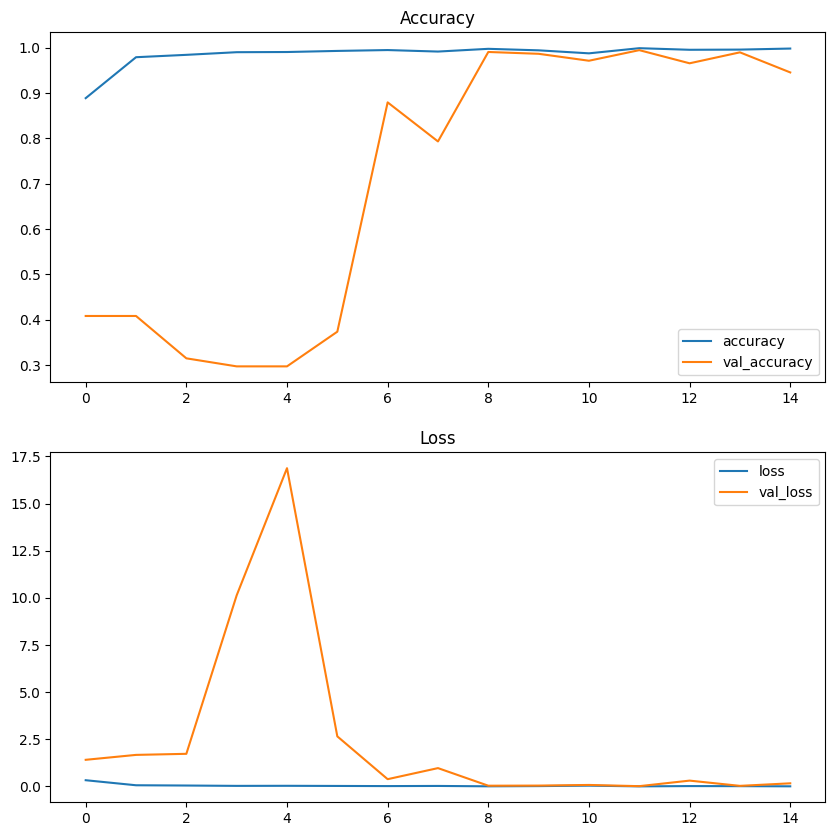

In [167]:
plot_model_history(HistoryResultDF5)

In [168]:
ModelValues5 = ModelValues(HistoryResultDF5)
Loss5, Accuracy5, ValLoss5, ValAccuracy5, LossAccuracyValuesDf5 = ModelValues5.loss_accuracy_values()
MaxLoss5, MaxAccuracy5, MaxValLoss5, MaxValAccuracy5, MaxLossAccuracyValuesDf5 = ModelValues5.loss_accuracy_valuesـmaximum_values()
MinLoss5, MinAccuracy5, MinValLoss5, MinValAccuracy5, MinLossAccuracyValuesDf5 = ModelValues5.loss_accuracy_valuesـminimum_values()

In [169]:
LossAccuracyValuesDf5

,Values
Loss,0.045997
Accuracy,0.985057
Val_Loss,2.434784
Val_Accuracy,0.707568


In [170]:
MaxLossAccuracyValuesDf5

,Values
Max_Loss,0.330074
Max_Accuracy,0.998693
Max_Val_Loss,16.876358
Max_Val_Accuracy,0.994364


In [171]:
MinLossAccuracyValuesDf5

,Values
Min_Loss,0.004052
Min_Accuracy,0.888532
Min_Val_Loss,0.014894
Min_Val_Accuracy,0.297101


In [172]:
TestingLoss5, TestingAccuracy5, EvaluationValues5 = model_evulation(model5, Testing_Set)

In [173]:
EvaluationValues5

,Values
Loss,0.022307
Accuracy,0.993585


In [174]:
Real5, Predictions5 = generate_real_prediction_classes(model5)

In [175]:
ConfusionMatrix5 = confusion_matrix_(Real5, Predictions5)

In [176]:
Positive5 = Generate_Positive(ConfusionMatrix5)
TruePositive5 = Positive5.true_positive()
FalsePostive5 = Positive5.false_positive()

In [177]:
Negative5 = Generate_Negative(ConfusionMatrix5)
TrueNegative5 = Negative5.true_negative()
FalseNegative5 = Negative5.false_negative()

In [178]:
Performance5 = Performance_Metrics(TruePositive5, TrueNegative5 ,FalsePostive5, FalseNegative5)

Accuracy5 = Performance5.accuracy_score()
Precision5 = Performance5.precision_score()
Sensitivity5 = Performance5.sensitivity_score()
Specificity5 = Performance5.specificity_score()
F1Score5 = Performance5.f1_score()
ErrorRate5 = Performance5.err_rate()

PerformanceValues5 = Performance5.display_performance_metrics_values(Accuracy5, Precision5, Sensitivity5, Specificity5, F1Score5, ErrorRate5)

In [179]:
PerformanceValues5

,Values
Accuracy,0.996792
Precision,0.993585
Sensitivity,0.993585
Specificity,0.997862
F1Score,0.993585
Error,0.003208


In [180]:
predict_image(model5, Predictin_Image1)

1/1 [==============================] - 2s 2s/step
Normal


In [181]:
predict_image(model5, Predictin_Image2)

1/1 [==============================] - 0s 31ms/step
Cyst


In [182]:
predict_image(model5, Predictin_Image3)

1/1 [==============================] - 0s 325ms/step
Stone


In [183]:
predict_image(model5, Predictin_Image4)

1/1 [==============================] - 0s 22ms/step
Tumor


In [184]:
predict_image(model5, Predictin_Image5)

1/1 [==============================] - 0s 21ms/step
Normal


In [185]:
predict_image(model5, Predictin_Image6)

1/1 [==============================] - 0s 435ms/step
Stone


In [186]:
predict_image(model5, Predictin_Image7)

1/1 [==============================] - 0s 23ms/step
Cyst


In [187]:
predict_image(model5, Predictin_Image8)

1/1 [==============================] - 0s 27ms/step
Tumor


In [188]:
model5.save("model5.h5")

**6. VGG19**

In [189]:
name = 'VGG19'

In [190]:
with tf.device('GPU'):
        base_model = tf.keras.applications.xception.VGG19(
                include_top=False,
                weights='imagenet',
                pooling='avg'
                )
        Con = Models(Input_Shape, Epochs)
        model6 = Con.tranfer_learning(base_model)

AttributeError: module 'keras.api._v2.keras.applications.xception' has no attribute 'VGG19'

In [ ]:
HistoryResultDF6= model_history_values(model6, name)

In [ ]:
HistoryResultDF6

In [ ]:
plot_model_history(HistoryResultDF6)

In [ ]:
ModelValues6 = ModelValues(HistoryResultDF6)
Loss6, Accuracy6, ValLoss6, ValAccuracy6, LossAccuracyValuesDf6 = ModelValues6.loss_accuracy_values()
MaxLoss6, MaxAccuracy6, MaxValLoss6, MaxValAccuracy6, MaxLossAccuracyValuesDf6 = ModelValues6.loss_accuracy_valuesـmaximum_values()
MinLoss6, MinAccuracy6, MinValLoss6, MinValAccuracy6, MinLossAccuracyValuesDf6 = ModelValues6.loss_accuracy_valuesـminimum_values()

In [ ]:
LossAccuracyValuesDf6

In [ ]:
MaxLossAccuracyValuesDf6

In [ ]:
MinLossAccuracyValuesDf6

In [ ]:
TestingLoss6, TestingAccuracy6, EvaluationValues6 = model_evulation(model6, Testing_Set)

In [ ]:
EvaluationValues6

In [ ]:
Real6, Predictions6 = generate_real_prediction_classes(model6)

In [ ]:
ConfusionMatrix6 = confusion_matrix_(Real6, Predictions6)

In [ ]:
Positive6 = Generate_Positive(ConfusionMatrix6)
TruePositive6 = Positive6.true_positive()
FalsePostive6 = Positive6.false_positive()

In [ ]:
Negative6 = Generate_Negative(ConfusionMatrix6)
TrueNegative6 = Negative6.true_negative()
FalseNegative6 = Negative6.false_negative()

In [ ]:
Performance6 = Performance_Metrics(TruePositive6, TrueNegative6 ,FalsePostive6, FalseNegative6)

Accuracy6 = Performance6.accuracy_score()
Precision6 = Performance6.precision_score()
Sensitivity6 = Performance6.sensitivity_score()
Specificity6 = Performance6.specificity_score()
F1Score6 = Performance6.f1_score()
ErrorRate6 = Performance6.err_rate()

PerformanceValues6 = Performance6.display_performance_metrics_values(Accuracy6, Precision6, Sensitivity6, Specificity6, F1Score6, ErrorRate6)

In [ ]:
PerformanceValues6

In [ ]:
predict_image(model6, Predictin_Image1)

In [ ]:
predict_image(model6, Predictin_Image2)

In [ ]:
predict_image(model6, Predictin_Image3)

In [ ]:
predict_image(model6, Predictin_Image4)

In [ ]:
predict_image(model6, Predictin_Image5)

In [ ]:
predict_image(model6, Predictin_Image6)

In [ ]:
predict_image(model6, Predictin_Image7)

In [ ]:
predict_image(model6, Predictin_Image8)

In [ ]:
model6.save("model6.h5")

# All Result

In [ ]:
Result = {
        'Training_Loss':[Loss0, Loss1, Loss2, Loss3, Loss4, Loss5, Loss6],
         'Training_Accuracy': [Accuracy0, Accuracy1, Accuracy2, Accuracy3, Accuracy4, Accuracy5, Accuracy6],
         'Val_Loss': [ValLoss0, ValLoss1, ValLoss2, ValLoss3, ValLoss4, ValLoss5, ValLoss6],
         'Val_Accuracy': [ValAccuracy0, ValAccuracy1, ValAccuracy2, ValAccuracy3, ValAccuracy4, ValAccuracy5, ValAccuracy6],
         'Testing_Loss':[TestingLoss0, TestingLoss1, TestingLoss2, TestingLoss3, TestingLoss4, TestingLoss5, TestingLoss6],
         'Testing_Accuracy':[TestingAccuracy0, TestingAccuracy1, TestingAccuracy2, TestingAccuracy3, TestingAccuracy4, TestingAccuracy5, TestingAccuracy6],
         'Accuracy':[Accuracy0, Accuracy1, Accuracy2, Accuracy3, Accuracy4, Accuracy5, Accuracy6],
         'Precision':[Precision0, Precision1, Precision2, Precision3, Precision4, Precision5, Precision6],
         'Sensitivity':[Sensitivity0, Sensitivity1, Sensitivity2, Sensitivity3, Sensitivity4, Sensitivity5, Sensitivity6],
         'Specificity':[Specificity0, Specificity1, Specificity2, Specificity3, Specificity4, Specificity5, Specificity6],
         'F1Score': [F1Score0, F1Score1, F1Score2, F1Score3, F1Score4, F1Score5, F1Score6],
         'ErrorRate':[ErrorRate0, ErrorRate1, ErrorRate2, ErrorRate3, ErrorRate4, ErrorRate5, ErrorRate6]
         }

In [ ]:
AllResult = pd.DataFrame(Result, index = ['Convolutional Neural Network', 'InceptionV3', 'DenseNet121', 'MobileNet', 'Xception', 'ResNet50', 'VGG19'])

In [ ]:
AllResult